In [1]:
import sys
sys.path.append("../code/")
from common import APPLIANCES_ORDER
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tensor = np.load('../1H-input.npy')

In [4]:
def create_subset_dataset(tensor, start=160, num_days=112):
    t_subset = tensor[:, :, start:start+num_days, :]
    all_indices = np.array(list(range(320)))
    for i in range(1, 7):
        valid_homes = pd.DataFrame(t_subset[:, i, :].reshape(320, num_days*24)).dropna().index
        all_indices = np.intersect1d(all_indices, valid_homes)
    print(len(all_indices))
    t_subset = t_subset[all_indices, :, :, :].reshape(len(all_indices), 7, num_days*24)
    
    # Create artificial aggregate
    t_subset[:, 0, :] = 0.0
    for i in range(1, 7):
        t_subset[:, 0, :] = t_subset[:, 0, :] + t_subset[:, i, :]
    # t_subset is of shape (#home, appliance, days*hours)
    return t_subset, all_indices

In [5]:
t_all, valid_homes = create_subset_dataset(tensor)
t_all.shape

52


(52, 7, 2688)

In [6]:
def my_objective(y_pred, y_true):
    with tf.name_scope(None):
        return tf.losses.absolute_difference(y_pred, y_true)

In [7]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
import keras
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
n_movies = 3
n_users=3
n_latent_factors=2

Using TensorFlow backend.


In [8]:
num_days = 112

In [9]:
train_agg = t_all[:30, 0, :].reshape(30*num_days, 24)

train_hvac = t_all[:30, 1, :].reshape(30*num_days, 24)
train_fridge = t_all[:30, 2, :].reshape(30*num_days, 24)
train_mw = t_all[:30, 3, :].reshape(30*num_days, 24)
train_dw = t_all[:30, 4, :].reshape(30*num_days, 24)
train_wm = t_all[:30, 5, :].reshape(30*num_days, 24)
train_oven = t_all[:30, 6, :].reshape(30*num_days, 24)








train_agg_new = train_hvac + train_fridge





test_hvac = t_all[30:52, 1, :].reshape(22*num_days, 24)
test_fridge = t_all[30:52, 2, :].reshape(22*num_days, 24)
test_mw = t_all[30:52, 3, :].reshape(22*num_days, 24)
test_dw = t_all[30:52, 4, :].reshape(22*num_days, 24)
test_wm = t_all[30:52, 5, :].reshape(22*num_days, 24)
test_oven = t_all[30:52, 6, :].reshape(22*num_days, 24)
test_appliance = t_all[30:52, 1:, :].reshape(22*num_days, 6*24)









test_agg = t_all[30:, 0, :].reshape(22*num_days, 24)
test_agg_new = test_hvac + test_fridge



In [10]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [11]:
train_hvac_fridge = np.hstack([train_hvac, train_fridge])
train_all_appliances = np.hstack([train_hvac, train_fridge, train_mw, train_dw, train_wm, train_oven])
test_all_appliances = np.hstack([test_hvac, test_fridge, test_mw, test_dw, test_wm, test_oven])

In [12]:
train_hvac.shape, test_all_appliances.shape

((3360, 24), (2464, 144))

In [13]:
ENERGY_MEAN = {APPLIANCES_ORDER[i]:np.mean(t_all[:, i, :]) for i in list(range(1, 7))}
ENERGY_MEAN = pd.Series(ENERGY_MEAN)
ENERGY_MEAN.sort_values(inplace=True, ascending=False)
ENERGY_MEAN

hvac      972.691387
fridge     88.831789
oven       16.751671
dw         14.304646
mw          6.215498
wm          4.932920
dtype: float64

In [14]:
num_iterations_dictionary = {'hvac':1200,'fridge':400,'mw':150,'dw':150,'oven':150, 'wm':150}



In [17]:
np.random.seed(0)
from keras.layers.merge import Subtract, Minimum, Multiply, Maximum
import keras.backend as K
from keras.layers import Reshape

layers = {}
appliance="hvac"


In [19]:
np.random.seed(0)
layers['Aggregate'] = keras.layers.Input(shape=[24],name='Aggregate')
for appliance_num, appliance in enumerate(ENERGY_MEAN.index[:]):
    if appliance_num==0:
        prev = 'Aggregate'
        layers['{}-dense'.format(appliance)] = keras.layers.Dense(units=50,name='{}-layer-1'.format(appliance), activation='relu')(layers['Aggregate'])
    else:
        prev = 'Subtracting-{}'.format(ENERGY_MEAN.index[appliance_num-1])
        layers['{}-dense'.format(appliance)] = keras.layers.Dense(units=50,name='{}-layer-1'.format(appliance), activation='relu')(layers[prev])
    print(appliance, prev)
    layers['{}-dropout'.format(appliance)] = keras.layers.Dropout(rate=0.05,name='Droput-{}'.format(appliance))(layers['{}-dense'.format(appliance)])
    layers['{}-output'.format(appliance)]= keras.layers.Dense(units=24,name='{}-output'.format(appliance), activation='relu')(layers['{}-dropout'.format(appliance)])
    layers['{}-clipped-output'.format(appliance)] = Minimum(name='Clipped-{}'.format(appliance))([layers['{}-output'.format(appliance)], layers['Aggregate']])
    
    # Subtracting out appliance from prev
    layers['Subtracting-{}'.format(appliance)] = Subtract(name='Subtracting-{}'.format(appliance))([layers[prev], layers['{}-clipped-output'.format(appliance)]])
    




concat = keras.layers.merge([layers['{}-clipped-output'.format(appliance)] for appliance in APPLIANCES_ORDER[1:]], mode='concat',name='Concat')
concat_reshape = Reshape((-1,1))(concat)
model = keras.Model(layers['Aggregate'], concat_reshape )

with open('tree.pdf','wb') as f:
    f.write(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='pdf'))



#SVG(model_to_dot(model,  show_shapes=False, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

hvac Aggregate
fridge Subtracting-hvac
oven Subtracting-fridge
dw Subtracting-oven
mw Subtracting-dw
wm Subtracting-mw


In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Aggregate (InputLayer)          (None, 24)           0                                            
__________________________________________________________________________________________________
hvac-layer-1 (Dense)            (None, 50)           1250        Aggregate[0][0]                  
__________________________________________________________________________________________________
Droput-hvac (Dropout)           (None, 50)           0           hvac-layer-1[0][0]               
__________________________________________________________________________________________________
hvac-output (Dense)             (None, 24)           1224        Droput-hvac[0][0]                
__________________________________________________________________________________________________
Clipped-hv

In [22]:
np.random.seed(0)
model.compile('adam','mean_absolute_error',)
model.fit(train_agg, train_all_appliances.reshape(-1, 144,1), epochs=300, validation_split=0.1)

Train on 3024 samples, validate on 336 samples
Epoch 1/300
3024/3024 [==============================] - 1s 482us/step - loss: 143.1516 - val_loss: 88.5607
Epoch 2/300
3024/3024 [==============================] - 0s 85us/step - loss: 71.2425 - val_loss: 58.5651
Epoch 3/300
3024/3024 [==============================] - 0s 85us/step - loss: 53.1564 - val_loss: 56.0181
Epoch 4/300
3024/3024 [==============================] - 0s 87us/step - loss: 49.4664 - val_loss: 52.3783
Epoch 5/300
3024/3024 [==============================] - 0s 86us/step - loss: 46.7906 - val_loss: 51.7132
Epoch 6/300
3024/3024 [==============================] - 0s 90us/step - loss: 46.1920 - val_loss: 51.4646
Epoch 7/300
3024/3024 [==============================] - 0s 96us/step - loss: 46.0367 - val_loss: 51.3098
Epoch 8/300
3024/3024 [==============================] - 0s 97us/step - loss: 45.9310 - val_loss: 50.9033
Epoch 9/300
3024/3024 [==============================] - 0s 91us/step - loss: 45.8614 - val_loss: 50.48

Epoch 77/300
3024/3024 [==============================] - 0s 106us/step - loss: 40.3174 - val_loss: 44.9854
Epoch 78/300
3024/3024 [==============================] - 0s 94us/step - loss: 40.3363 - val_loss: 44.4758
Epoch 79/300
3024/3024 [==============================] - 0s 93us/step - loss: 40.2061 - val_loss: 44.6242
Epoch 80/300
3024/3024 [==============================] - 0s 97us/step - loss: 40.1118 - val_loss: 45.0204
Epoch 81/300
3024/3024 [==============================] - 0s 101us/step - loss: 40.1366 - val_loss: 44.9361
Epoch 82/300
3024/3024 [==============================] - 0s 121us/step - loss: 40.0377 - val_loss: 44.6567
Epoch 83/300
3024/3024 [==============================] - 0s 118us/step - loss: 39.9748 - val_loss: 44.7713
Epoch 84/300
3024/3024 [==============================] - 0s 115us/step - loss: 39.9409 - val_loss: 44.8005
Epoch 85/300
3024/3024 [==============================] - 0s 85us/step - loss: 39.8972 - val_loss: 44.8672
Epoch 86/300
3024/3024 [========

KeyboardInterrupt: 

In [23]:
pd.DataFrame((train_hvac/train_agg)).mean().mean()

0.7043994319811072

In [24]:
wei

array([[  976.53334117,   653.69999552,   574.51665497, ...,
         1957.50004625,  1517.31663609,  1173.9167099 ],
       [  845.69997406,   697.05001402,   423.41665649, ...,
         1956.49994659,  1549.41660595,  1202.56661844],
       [  937.24997711,   724.29998779,   529.55000615, ...,
         1624.01667595,  1250.03333378,  1054.63332987],
       ..., 
       [  525.66667373,   484.96665942,   322.56666691, ...,
          601.26665354,   430.56667852,   408.9833334 ],
       [  370.85001683,   368.36666756,    69.00000143, ...,
          399.6166724 ,   903.08335161,   895.78330398],
       [  778.50002294,   479.43333673,   406.26666093, ...,
          782.66666513,   499.7666657 ,   713.23331504]])

In [25]:
model.predict(test_agg)[:, :24].shape
test_hvac.shape
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [28]:
pred_hvac = model.predict(test_agg)[:, :24].reshape(-1,24)
pred_fridge = model.predict(test_agg)[:, 24:48].reshape(-1,24)
pred_mw = model.predict(test_agg)[:, 48:72].reshape(-1,24)
pred_dw = model.predict(test_agg)[:, 72:96].reshape(-1,24)
pred_wm = model.predict(test_agg)[:, 96:120].reshape(-1,24)
pred_oven = model.predict(test_agg)[:, 120:].reshape(-1,24)








from sklearn.metrics import mean_absolute_error

mae = {}
for appliance in APPLIANCES_ORDER[1:]:
    mae[appliance] = mean_absolute_error(eval("test_"+appliance), eval("pred_"+appliance))
print(pd.Series(mae).mean())
mae

37.06045125779605


{'dw': 14.202017322299449,
 'fridge': 34.525775454924933,
 'hvac': 143.54679101126561,
 'mw': 6.0545020537347343,
 'oven': 18.541556804425667,
 'wm': 5.4920649001259818}

In [152]:

print(mean_absolute_error(pred_hvac, test_hvac))
print(mean_absolute_error(pred_fridge, test_fridge))
print(mean_absolute_error(pred_mw, test_mw))
print(mean_absolute_error(pred_dw, test_dw))
print(mean_absolute_error(pred_wm, test_wm))
print(mean_absolute_error(pred_oven, test_oven))








#print(mean_absolute_error(test_agg, pred_hvac))



118.66618611
32.9917797529
6.05450205373
14.5808043014
5.49206490013
18.1072201031


In [66]:
(128.56+32.71+6.05+14.2+5.5+18.75)/6

34.295

In [28]:
pd.DataFrame(model.predict(test_agg)[:, :]).mean().mean()

203.05189514160156

In [29]:
pd.DataFrame(test_fridge).sum(axis=1).describe()

count    2464.000000
mean     2088.788108
std       750.622251
min         0.000000
25%      1712.175005
50%      2041.358347
75%      2457.379175
max      4060.083328
dtype: float64

In [30]:
pd.DataFrame(test_fridge).iloc[84]

0      45.516666
1      64.349998
2      68.233330
3      67.383331
4      66.900002
5      89.116669
6      74.183334
7     119.566666
8      79.349998
9      78.300003
10     51.716667
11     31.016666
12    137.566666
13     84.550003
14    113.333336
15     76.766670
16     32.966667
17    138.899994
18     53.283333
19     62.366665
20     92.683334
21     36.716667
22     68.150002
23     82.449997
Name: 84, dtype: float64

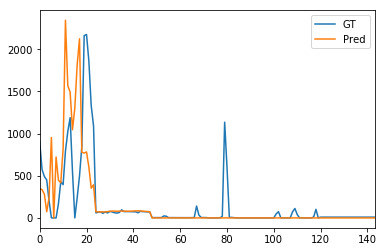

In [31]:
#pd.Series(train_appliance[0]).plot()
pd.Series(train_all_appliances[0]).plot(label='GT')
pd.Series(model.predict(test_agg)[0, :]).plot(label='Pred')
plt.legend()

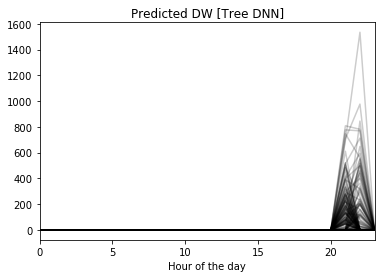

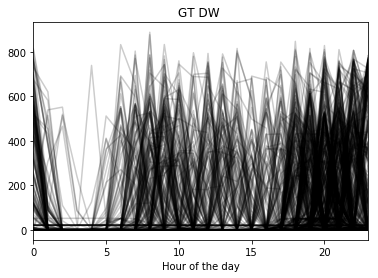

In [151]:
pd.DataFrame(pred_dw).T.plot(legend=False, color='k',alpha=0.2)
plt.title("Predicted DW [Tree DNN]")
plt.xlabel("Hour of the day")
pd.DataFrame(test_dw).T.plot(legend=False, color='k',alpha=0.2)
plt.title("GT DW ")
plt.xlabel("Hour of the day")

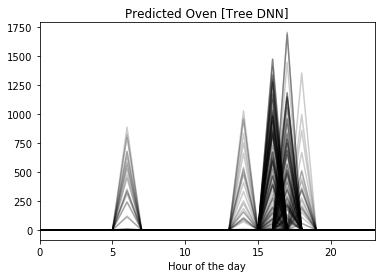

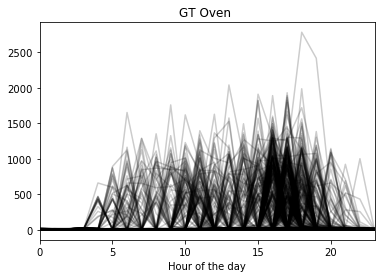

In [150]:
pd.DataFrame(pred_oven).T.plot(legend=False, color='k',alpha=0.2)
plt.title("Predicted Oven [Tree DNN]")
plt.xlabel("Hour of the day")
pd.DataFrame(test_oven).T.plot(legend=False, color='k',alpha=0.2)
plt.title("GT Oven ")
plt.xlabel("Hour of the day")

In [218]:
pd.DataFrame(pred_hvac-test_agg).describe()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
count,308.000000,308.000000,308.000000,3.080000e+02,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,...,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000
mean,-8.719855,-45.614794,-7.135415,-7.971667e+00,-7.172175,-18.480223,-147.513609,-152.453793,-27.035719,-64.666421,...,-8.413468,-19.909490,-42.936754,-47.697094,-47.043026,-21.094335,-6.990199,-31.927933,-46.293898,-85.879873
std,45.109670,60.061834,30.859192,3.269325e+01,28.594266,119.532227,82.758541,69.688543,61.122479,86.484157,...,51.907125,126.876979,163.263836,149.381453,146.882644,69.227755,50.543880,104.734850,109.939533,103.596838
min,-543.816655,-437.150538,-342.366671,-3.337500e+02,-287.800001,-1889.948818,-1069.916657,-357.506195,-377.699986,-662.013244,...,-736.833309,-1841.840468,-1209.334181,-1165.487390,-1245.134079,-462.636366,-772.333338,-892.741325,-723.091827,-593.544623
25%,-0.000021,-84.867813,-0.000011,-1.442432e-05,-0.000011,-0.000016,-169.689933,-194.442911,-0.000053,-95.100000,...,-0.000032,-0.000040,-0.000061,-0.000068,-0.000078,-0.000050,-0.000031,-0.000045,-0.000074,-128.070320
50%,-0.000001,-18.655516,0.000000,-4.768372e-07,0.000000,0.000000,-132.160551,-156.783971,-0.000007,-46.194264,...,0.000000,-0.000001,-0.000007,-0.000015,-0.000014,-0.000011,-0.000004,-0.000004,-0.000008,-58.803405
75%,0.000008,-0.000004,0.000009,7.629395e-06,0.000007,0.000006,-106.392542,-106.963121,0.000006,-0.000019,...,0.000033,0.000026,0.000023,0.000015,0.000015,0.000015,0.000020,0.000014,0.000007,-0.000012
max,0.000061,0.000050,0.000058,5.793571e-05,0.000079,0.000116,0.000009,0.000004,0.000082,0.000054,...,0.000242,0.000233,0.000221,0.000226,0.000158,0.000194,0.000221,0.000099,0.000094,0.000059


In [40]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [62]:
pd.DataFrame(pred_wm)
pd.DataFrame(test_wm).max()

0      152.100006
1       64.983330
2       56.566666
3       80.933334
4      178.083328
5      182.300003
6      396.783325
7      380.316681
8      389.233337
9      579.233337
10     855.416687
11     584.866638
12    1000.166687
13     688.416687
14     376.350006
15    1015.416687
16    1046.633301
17     936.400024
18     749.533325
19     941.666687
20    1025.233276
21     991.816650
22    1007.716675
23     436.816681
dtype: float64

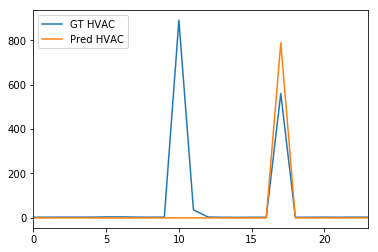

In [58]:
#pd.Series(test_agg[1, :]).plot(label='GT Agg')
pd.Series(test_oven[17, :]).plot(label='GT HVAC')
pd.Series(pred_oven[17, :]).plot(label='Pred HVAC')


#pd.Series(test_wm[1, :]).plot(label='GT HVAC')


#pd.Series(test_fridge[1, :]).plot(label='GT Fridge')


#pd.Series(test_mw[1, :]).plot(label='GT MW')
#pd.Series(test_oven[1, :]).plot(label='GT Oven')







#pd.Series(model.predict(test_agg[1:2])[0, :24]).plot(label='Pred HVAC')
#pd.Series(model.predict(test_agg[1:2])[0, 24:48]).plot(label='Pred HVAC')


#pd.Series(model.predict(test_agg[1:2])[0, 24:]).plot(label='Pred Fridge')




plt.legend()

In [37]:
print(np.mean(pred_fridge), np.mean(test_fridge))
np.mean(pred_hvac), np.mean(test_hvac), np.mean(test_agg)

83.1671 87.0328378424


(1134.5818, 1018.3708339143896, 1149.5817138954521)

In [38]:
(pd.DataFrame(test_fridge)-pd.DataFrame(pred_fridge)).abs().sum(axis=1).argmax()

1191

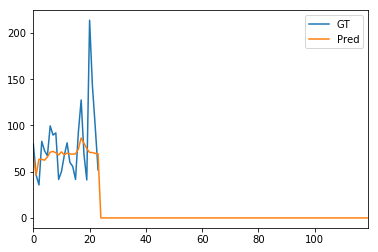

In [39]:
pd.Series(test_fridge[1, :]).plot(label='GT')
pd.Series(model.predict(test_agg_new[1:2])[0, 24:]).plot(label='Pred')


plt.legend()